### <center>Megafon Project. Binary classification model<a class="anchor" id="course_project"></a><center>

Company "Megafon" has submitted a request for classfication project. The dataset provided given the id of the users, target and list of undefined features. The metric used to classify the best model should be ROC-AUC score

Given data: <br>
`binary_project.csv`: id, target, feature list <br>
Scoring of the model is based on ROC-AUC score

# 1 Baseline

Downloading the data, creating a baseline solution, checking the metrics to further build-on modifications of the model

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.1.


### 1.1 Source data

In [6]:
data = pd.read_csv('binary_project.csv')
data.shape

(24521, 262)

In [7]:
data.head()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,...,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
0,1053371037,1,2.0,2.0,0.0,0.0,0.0,0.0,0.0,-114.527812,...,39.0,2.0,223.118594,290.015143,1.0,1.0,0.0,1.0,2.0,2.0
1,76507184,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,329.828334,...,25.0,82.0,479.616045,611.651594,0.0,1.0,0.0,1.0,1.0,1.0
2,76753690,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.427338,...,119.0,0.0,352.268014,564.573421,1.0,1.0,0.0,1.0,1.0,1.0
3,1026167358,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,23.621397,...,1.0,0.0,410.524985,421.653876,1.0,0.0,0.0,1.0,2.0,2.0
4,7220095746,0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,677.745861,...,21.0,0.0,439.171356,476.189288,1.0,1.0,0.0,1.0,1.0,1.0


In [8]:
data = data.set_index('ID')

In [9]:
# Разделим признаки и целевую переменную
data_prelim = data.copy()

X = data_prelim.drop('TARGET', axis=1)
y = data_prelim['TARGET']

In [24]:
print("ID is unique? ", X.index.is_unique)
print("Are the dublicates in rows?", X.duplicated().sum())
print("How many features are with na-values %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID is unique?  True
Are the dublicates in rows? 0
How many features are with na-values 20%


**20% of features have na-values**

### 1.2 Division on train test

0    0.708454
1    0.291546
Name: TARGET, dtype: float64

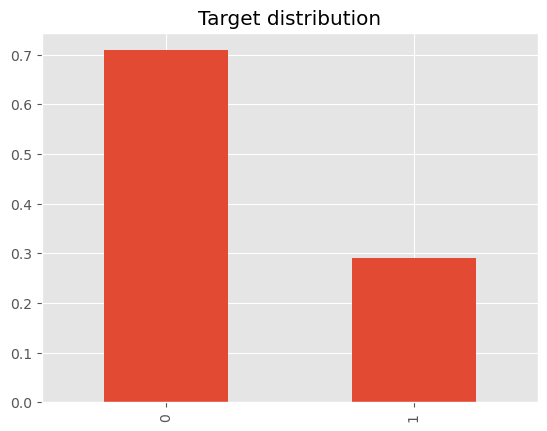

In [19]:
(y.value_counts()/y.shape[0]).plot(kind='bar', title='Target distribution');
y.value_counts()/y.shape

In [20]:
from sklearn.model_selection import train_test_split

# Fix the random state for results reproduction
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.3, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0    0.708809
1    0.291191
Name: TARGET, dtype: float64

Test
0    0.707625
1    0.292375
Name: TARGET, dtype: float64


Distribution of target in test and train datasets is equal, so we can proceed with model creation

### 1.3 Pipeline for baseline model

For baseline model we will proceed with logistics regression.

In [21]:
from sklearn.linear_model import LogisticRegression

step_log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))

In the dataset, about 20% of the attributes contain missing values. Since the logistic regression is not able to handle missing values, we have to fill them ourselves. To do this we will use the sklearn.impute.SimpleImputer class. This class has a strategy parameter, which defines how the missing values will be filled. It can take several values.

In [22]:
from sklearn.impute import SimpleImputer

For baseline model we fill in the na-values with mean for that feature.

In [25]:
step_imputer = ("imputer", SimpleImputer(strategy="mean"))

The basic Pipeline will consist of only two steps:
- Filling in the na-s by the average
- Logistic regression with basic parameters

In [26]:
from sklearn.pipeline import Pipeline

bl_estimator = Pipeline([
    step_imputer,
    step_log_reg
])

### 1.4 Cross-validation

For estimation of the quality of the model we will use 3-fold cross-validation.

In [34]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='roc_auc', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.3f (+/- %0.3f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [35]:
run_cv(bl_estimator, kfold_cv, X_train, y_train, model_name="Baseline");

Baseline: roc_auc = 0.639 (+/- 0.011)


### 1.5 Graphs and metrics of baseline model on test

In [36]:
bl_estimator.fit(X_train, y_train)

bl_y_pred = bl_estimator.predict_proba(X_test)[:,1]

#### ROC and PR Curves

In [37]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)

Baseline: AUC_ROC = 0.630


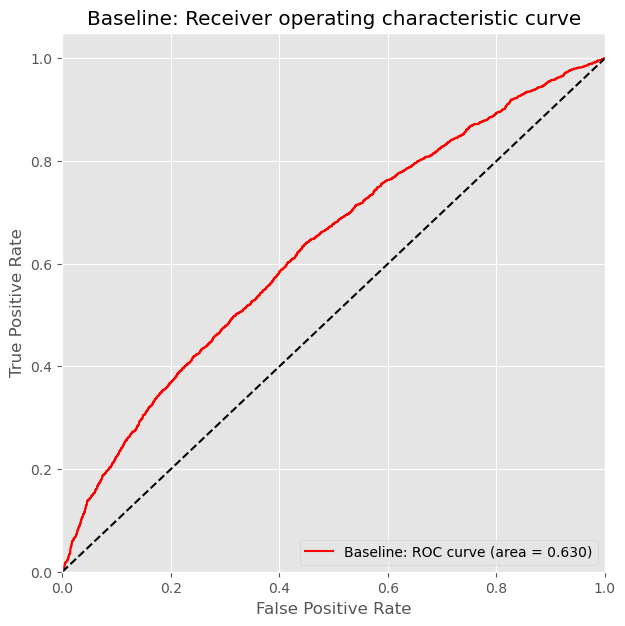

In [38]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.3f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.410


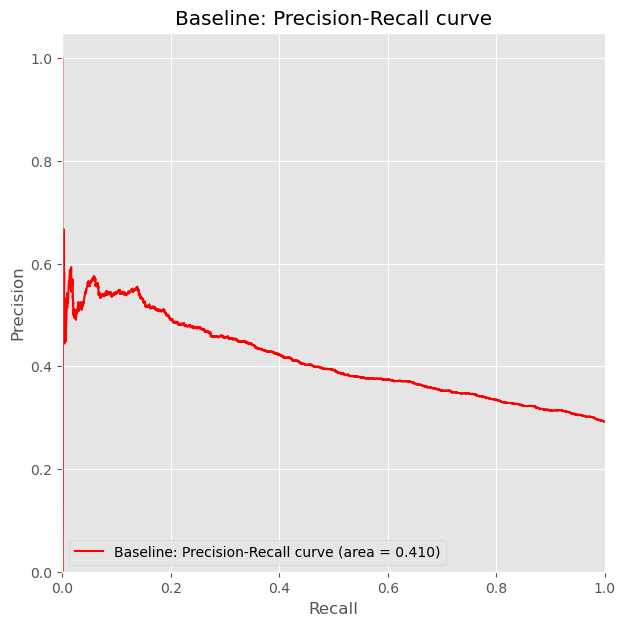

In [39]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.3f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

#### Confusion matrix

In [40]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[5150   56]
 [2093   58]]


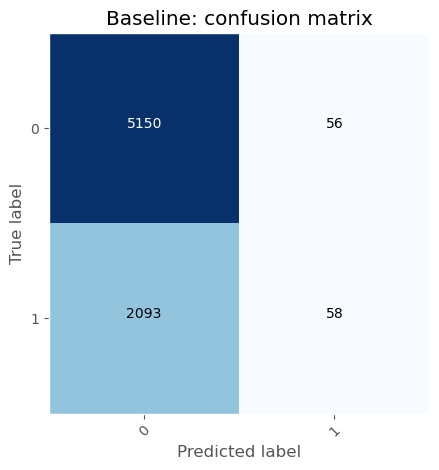

In [41]:
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

cm = confusion_matrix(y_test, bl_y_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="Baseline");

#### classification_report

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bl_y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83      5206
           1       0.51      0.03      0.05      2151

    accuracy                           0.71      7357
   macro avg       0.61      0.51      0.44      7357
weighted avg       0.65      0.71      0.60      7357



In [43]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(fp + tp)
recall = tp/(fn + tp)

accuracy = (tp + tn)/(fp + fn + tp + tn)

micro_avg_pr    = (tn + tp) / (fn + tn + fp + tp)
macro_avg_pr    = (tn/(fn + tn) + tp/(fp + tp))/2

n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
weighted_avg_pr = (n_0*tn/(fn + tn) + n_1*tp/(fp + tp))/(n_0 + n_1)

print("              accuracy = %.2f"   % float(accuracy))
print("           1 precision = %.2f"   % float(precision))
print("              1 recall = %.2f"   % float(recall))
print("   micro avg precision = %.2f "  % float(micro_avg_pr))
print("   macro avg precision = %.2f "  % float(macro_avg_pr))
print("weighted avg precision = %.2f "  % float(weighted_avg_pr))

              accuracy = 0.71
           1 precision = 0.51
              1 recall = 0.03
   micro avg precision = 0.71 
   macro avg precision = 0.61 
weighted avg precision = 0.65 


# 2 Definition of feature types

In [44]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [46]:
X_nunique.shape

(260,)

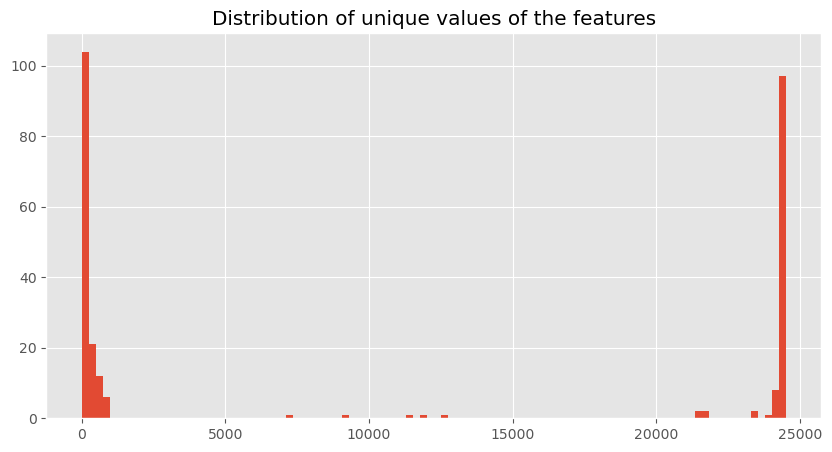

In [48]:
plt.title("Distribution of unique values of the features");
X_nunique.hist(bins=100, figsize=(10, 5));

In [49]:
f_all = set(X_nunique.index.tolist())
len(f_all)

260

#### Constant features

In [50]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

4

#### Physical features

In [51]:
f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

130

In [52]:
f_other = f_all - (f_numeric | f_const)
len(f_other)

126

#### Binary features

In [53]:
f_binary = set(X.loc[:, f_other].columns[(
                      (X.loc[:, f_other].max() == 1) & \
                      (X.loc[:, f_other].min() == 0) & \
                      (X.loc[:, f_other].isnull().sum() == 0))])
len(f_binary)

14

In [54]:
f_other = f_other - f_binary
len(f_other)

112

#### Categorical features

In [55]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
f_numeric_extra = f_categorical

In [56]:
f_other = f_other - f_categorical
len(f_other)

86

In [57]:
f_numeric = f_numeric | f_other

In [58]:
f_other = f_other - f_numeric
len(f_other)

0

In [59]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

In [60]:
print('f_all:', X.shape[1])
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 260

f_const: 4
f_binary: 14
f_categorical: 26
f_numeric: 216


# 3 Creation of Pipeline for features

### 3.1 Column Selector

In [61]:
from sklearn.base import BaseEstimator, TransformerMixin

In [62]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame do not contain following columns: %s" % cols_error)

### 3.2 Pipeline for features

In [63]:
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [64]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [65]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['FEATURE_58', 'FEATURE_220', 'FEATURE_132',
                          'FEATURE_146', 'FEATURE_17', 'FEATURE_72',
                          'FEATURE_182', 'FEATURE_139', 'FEATURE_237',
                          'FEATURE_89', 'FEATURE_196', 'FEATURE_11',
                          'FEATURE_223', 'FEATURE_68', 'FEATURE_183',
                          'FEATURE_137', 'FEATURE_189', 'FEATURE_219',
                          'FEATURE_142', 'FEATURE_75', 'FEATURE_47',
                          'FEATURE_136', 'FEATURE_97', 'FEATURE_205',
                          'FEATURE_26', 'FEATURE_112', 'FEATURE_253',
                          'FEATURE_74', 'FEATURE_224', 'FEATURE_77', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['FEATURE_13',
                                            

In [66]:
X_test.shape[1]

260

In [67]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

357

### 3.3 Gridsearch for pipelines

In [107]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

Search of parameters names

In [110]:
[k for k in lg_pipe.get_params().keys() if 'imputer' in k]

['pipeline__featureunion__numeric_features__simpleimputer',
 'pipeline__featureunion__numeric_features__simpleimputer__add_indicator',
 'pipeline__featureunion__numeric_features__simpleimputer__copy',
 'pipeline__featureunion__numeric_features__simpleimputer__fill_value',
 'pipeline__featureunion__numeric_features__simpleimputer__keep_empty_features',
 'pipeline__featureunion__numeric_features__simpleimputer__missing_values',
 'pipeline__featureunion__numeric_features__simpleimputer__strategy',
 'pipeline__featureunion__numeric_features__simpleimputer__verbose',
 'pipeline__featureunion__categorical_features__simpleimputer',
 'pipeline__featureunion__categorical_features__simpleimputer__add_indicator',
 'pipeline__featureunion__categorical_features__simpleimputer__copy',
 'pipeline__featureunion__categorical_features__simpleimputer__fill_value',
 'pipeline__featureunion__categorical_features__simpleimputer__keep_empty_features',
 'pipeline__featureunion__categorical_features__simpleimp

In [111]:
param_grid = {
    "pipeline__featureunion__categorical_features__simpleimputer__strategy": ['most_frequent', 'constant'],
    "pipeline__featureunion__categorical_features__simpleimputer__fill_value": [-1],
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}

Grid scores on development set:

0.701 (+/-0.007) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.701 (+/-0.007) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



Compare with baseline model with roc_auc = 0.639 (+/- 0.011)

In [114]:
param_grid = {
    "logisticregression__penalty": ['l1', 'l2'],
    "logisticregression__C": [0.01, 0.1, 1.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.703 (+/-0.006) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.702 (+/-0.007) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l1'}
0.701 (+/-0.007) for {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}



In [115]:
lg_gsc.best_params_

{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}

### 3.4 Selection of features in pipeline

In [116]:
from sklearn.feature_selection import SelectFromModel

The estimator attribute of the SelectFromModel class must have at least one of the feature_importances_ or coef_ attributes after the fit method is executed.

In [139]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=0.01, random_state=RANDOM_STATE), threshold=1e-2),
)

In [140]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(7357, 357)

In [141]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(7357, 272)

Logistic Regression from SelectFromModel deleted around 23% of features.

In [153]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=0.01, random_state=RANDOM_STATE), threshold=1e-2),
    LogisticRegression(penalty='l2', C=0.01, random_state=RANDOM_STATE)
)

In [154]:
param_grid = [
    {"selectfrommodel__max_features": [None, 5, 10, 50, 100, 150], "selectfrommodel__threshold": [-np.inf]},
    {"selectfrommodel__threshold": [1e-2]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.70

Best parameters set found on development set:

{'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.703 (+/-0.006) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.647 (+/-0.041) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.680 (+/-0.007) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.697 (+/-0.010) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.700 (+/-0.009) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.704 (+/-0.005) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.703 (+/-0.006) for {'selectfrommodel__threshold': 0.01}



# 4 Final Model

In [155]:
from xgboost import XGBClassifier

In [156]:
xgbc_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', C=0.01, random_state=RANDOM_STATE), max_features=150),
    XGBClassifier()
)

In [159]:
[k for k in xgbc_fs_pipe.get_params().keys() if 'xgbc' in k]

['xgbclassifier',
 'xgbclassifier__objective',
 'xgbclassifier__use_label_encoder',
 'xgbclassifier__base_score',
 'xgbclassifier__booster',
 'xgbclassifier__colsample_bylevel',
 'xgbclassifier__colsample_bynode',
 'xgbclassifier__colsample_bytree',
 'xgbclassifier__enable_categorical',
 'xgbclassifier__gamma',
 'xgbclassifier__gpu_id',
 'xgbclassifier__importance_type',
 'xgbclassifier__interaction_constraints',
 'xgbclassifier__learning_rate',
 'xgbclassifier__max_delta_step',
 'xgbclassifier__max_depth',
 'xgbclassifier__min_child_weight',
 'xgbclassifier__missing',
 'xgbclassifier__monotone_constraints',
 'xgbclassifier__n_estimators',
 'xgbclassifier__n_jobs',
 'xgbclassifier__num_parallel_tree',
 'xgbclassifier__predictor',
 'xgbclassifier__random_state',
 'xgbclassifier__reg_alpha',
 'xgbclassifier__reg_lambda',
 'xgbclassifier__scale_pos_weight',
 'xgbclassifier__subsample',
 'xgbclassifier__tree_method',
 'xgbclassifier__validate_parameters',
 'xgbclassifier__verbosity']

In [160]:
param_grid = {
    "xgbclassifier__learning_rate": [0.01, 0.05, 0.1], 
    "xgbclassifier__max_depth": [1, 5, 10],
    "xgbclassifier__n_estimators": [10, 100]
}

xgbc_fs_gsc = run_grid_search(xgbc_fs_pipe, X_train, y_train, param_grid, kfold_cv)

[20:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best roc_auc score: 0.71

Best parameters set found on development set:

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}

Grid scores on development set:

0.598 (+/-0.008) for {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 10}
0.645 (+/-0.008) for {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 100}
0.664 (+/-0.002) for {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 10}
0.689 (+/-0.005) for {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 5, 'xgbclas

### 4.1 Models comparison

In [161]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:,1]

In [162]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      5206
           1       0.65      0.24      0.35      2151

    accuracy                           0.74      7357
   macro avg       0.70      0.59      0.59      7357
weighted avg       0.72      0.74      0.69      7357



In [163]:
xgbc_fs_pipe_final = xgbc_fs_gsc.best_estimator_

xgbc_fs_pipe_final.fit(X_train, y_train)

xgbc_fs_pred = xgbc_fs_pipe_final.predict_proba(X_test)[:,1]

[20:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [177]:
print(classification_report(y_test, xgbc_fs_pred > 0.5))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      5206
           1       0.68      0.26      0.37      2151

    accuracy                           0.75      7357
   macro avg       0.72      0.60      0.61      7357
weighted avg       0.73      0.75      0.70      7357



Baseline: AUC_PR = 0.410
Baseline: AUC_ROC = 0.630
lg_fs_pred: AUC_PR = 0.522
lg_fs_pred: AUC_ROC = 0.702
xgbc_fs_pred: AUC_PR = 0.551
xgbc_fs_pred: AUC_ROC = 0.721


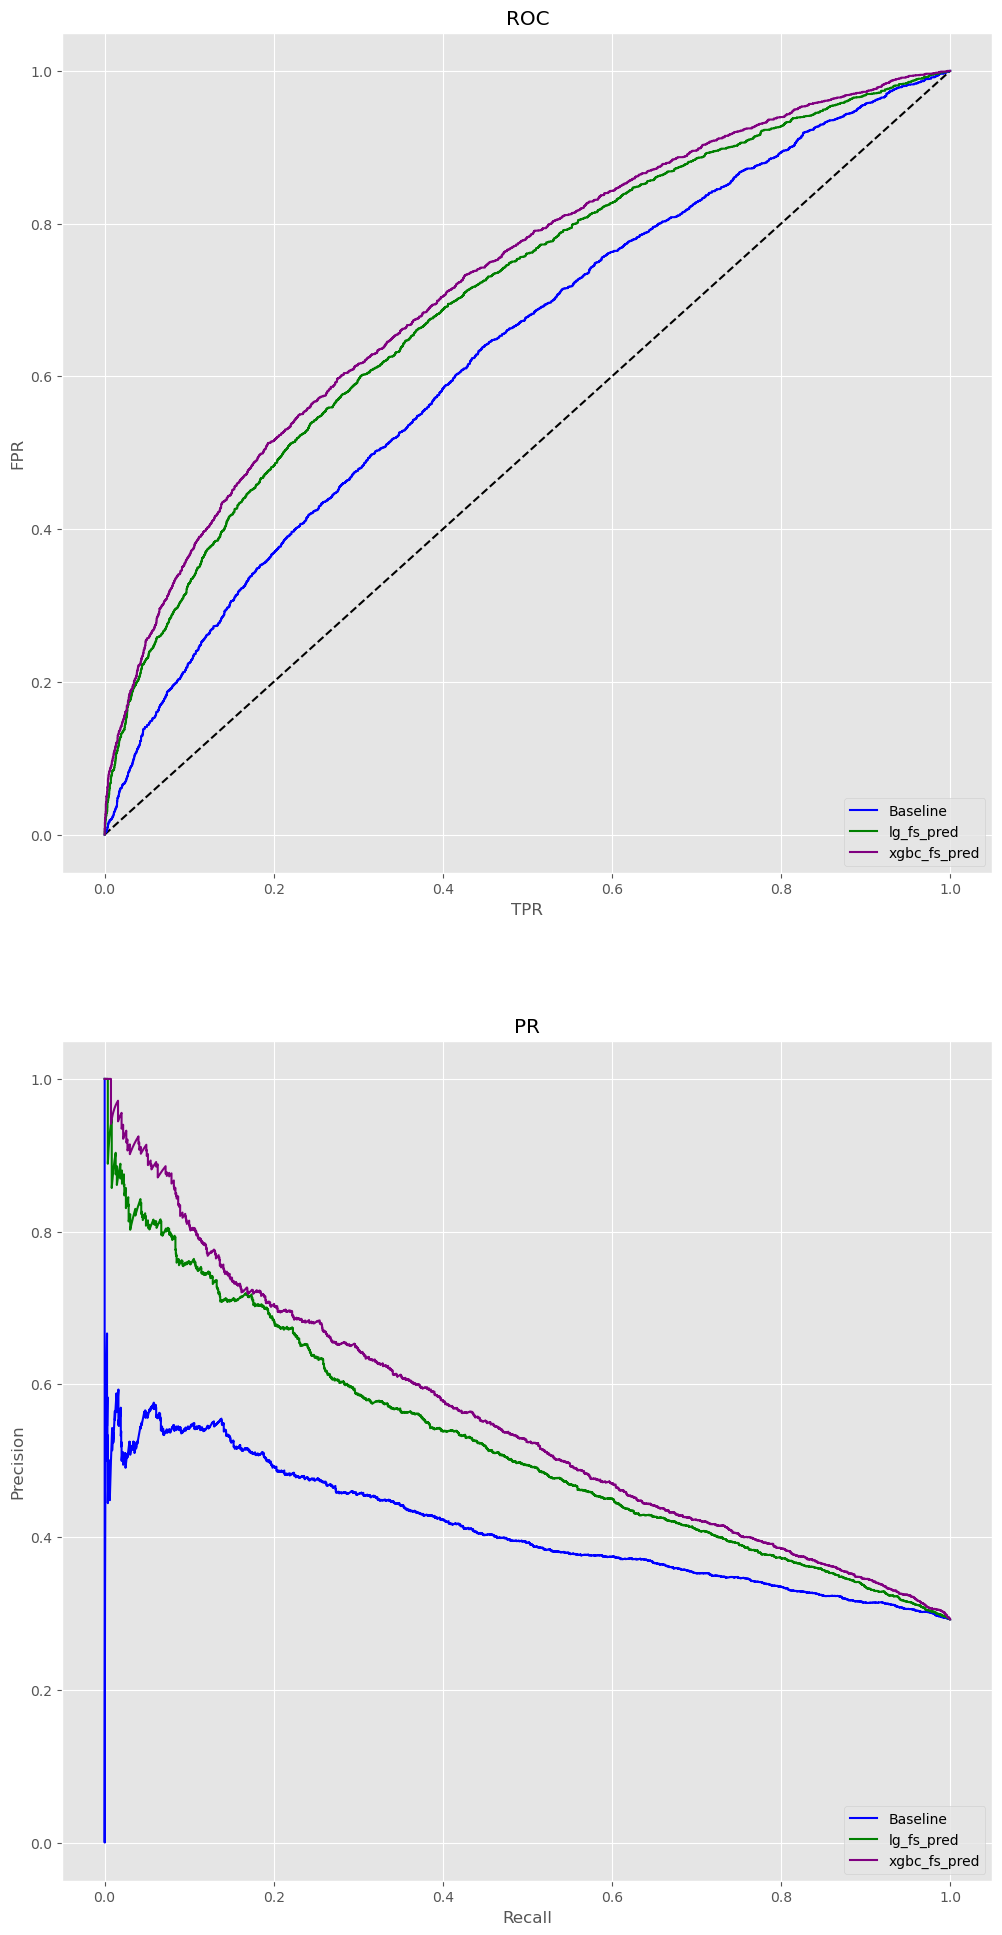

In [178]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, bl_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, bl_y_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label="lg_fs_pred", color='g')
ax2.plot(recall, precision, label="lg_fs_pred", color='g')
print("lg_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("lg_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, xgbc_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, xgbc_fs_pred)
ax1.plot(fpr, tpr, label="xgbc_fs_pred", color='purple')
ax2.plot(recall, precision, label="xgbc_fs_pred", color='purple')
print("xgbc_fs_pred: AUC_PR = %.3f" % auc(recall, precision))
print("xgbc_fs_pred: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

Confusion matrix, without normalization
[[4943  263]
 [1598  553]]


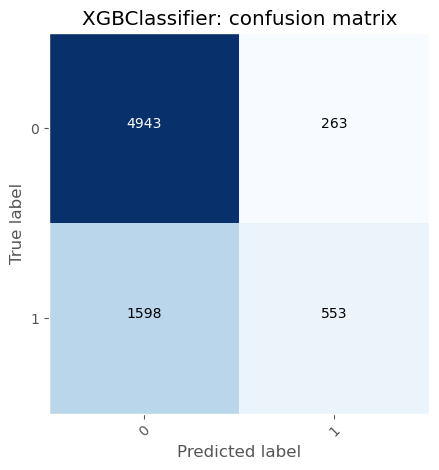

In [179]:
cm = confusion_matrix(y_test, xgbc_fs_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XGBClassifier");

### 4.2 Saving the model

In [195]:
import pickle

In [196]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(xgbc_fs_pipe_final, file)

In [197]:
xgbc_fs_pipe_final.fit(X, y)

predictions = xgbc_fs_pipe_final.predict_proba(X)[:,1]
result['ID'] = X.index
result['preduction'] = predictions

result.to_csv('predictions.csv', index=False)

[21:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
